In [76]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

In [77]:
def find_and_crop_paper(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, 50, 100)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    paper_contour = None

    for cnt in contours:
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        if len(approx) == 4:
            paper_contour = approx
            break

    image_area = img.shape[0] * img.shape[1]
    paper_contour_area = cv2.contourArea(paper_contour)
    if paper_contour_area < (1/3) * image_area:
        return img
    # Draw paper_contour on the image
    cv2.drawContours(img, [paper_contour], -1, (0, 255, 0), 2)


    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(img, cmap='gray')
    plt.show()

    if paper_contour is not None:
        pts1 = np.float32(paper_contour.reshape(-1, 2))
        pts2 = np.float32([[0, 0], [0, img.shape[0]], [img.shape[1], img.shape[0]], [img.shape[1], 0]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        warped = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0])) 

        return warped
    else:
        return img  # Return original image if no paper contour found

In [78]:
image = cv2.imread('../forms/qwert.png')
max_size = 3000
# image = find_and_crop_paper(image)
height, width = image.shape[:2]

if width > height:
    new_width = max_size
    ratio = max_size / width
    new_height = int(height * (max_size / width))
else:
    new_height = max_size
    ratio = max_size / height
    new_width = int(width * (max_size / height))
resized_image = cv2.resize(image, (new_width, new_height))

In [79]:
image = resized_image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 100)

In [80]:
data = pytesseract.image_to_data(edges, output_type=pytesseract.Output.DICT, config='--psm 11')

filtered_boxes = []
for i in range(len(data['level'])):
    (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
    confidence = int(data['conf'][i])
    if 500 >= w * h:
        continue
    aspect_ratio = float(w) / h
    if 1.1 >= aspect_ratio:
        continue
    if 1 > confidence:
        continue
    filtered_boxes.append((x, y, w, h))
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

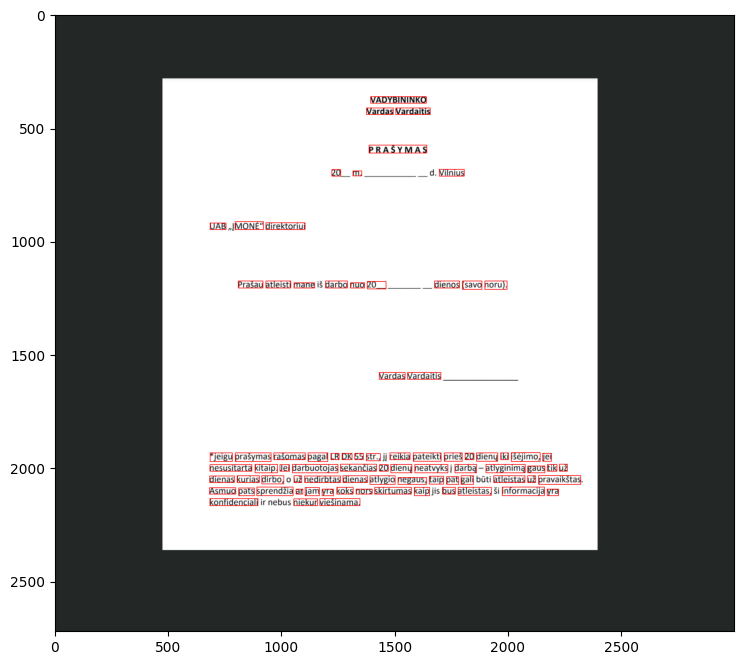

In [81]:
plt.figure(figsize=(10, 8))
plt.imshow(image, cmap='gray')
plt.show()

In [82]:
img_copy = resized_image.copy()
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # 3x3 rectangular kernel
dilated_image = cv2.dilate(edges, kernel, iterations=1)
lines = cv2.HoughLinesP(dilated_image, 1, np.pi/180, threshold=200, minLineLength=50, maxLineGap=3)
vertical_lines = filter(lambda line: abs(line[0][3] - line[0][1]) < 3, lines)
sorted_lines = sorted(vertical_lines, key=lambda line: line[0][1])

In [83]:
def filter_overlapping_lines(lines):
    filtered_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        overlaps = False
        for existing_line in filtered_lines:
            ex1, ey1, ex2, ey2 = existing_line
            if abs(y1 - ey2) > 50:
                continue
            if (x2 < ex1 or x1 > ex2):
                continue
            # x1 = min(x1, ex1)
            # x2 = max(x2, ex2)
            overlaps = True
            break
        if not overlaps:
            filtered_lines.append((x1, y1, x2, y2))

    return filtered_lines

aggregated_lines = filter_overlapping_lines(sorted_lines)
# print(len(aggregated_lines))
# for line in aggregated_lines:
#     x1, y1, x2, y2 = line
#     cv2.line(img_copy, (x1, y1), (x2, y2), (0, 0, 255), 2)


# plt.figure(figsize=(10, 8))
# plt.imshow(img_copy)
# plt.show()

(476, 278, 2391, 278)
(1364, 710, 1593, 710)
(1468, 1204, 1613, 1204)
(1803, 1610, 1974, 1612)
(1976, 1610, 2044, 1612)
(1859, 2057, 1910, 2057)
(953, 2160, 1041, 2160)
(476, 2361, 2393, 2361)


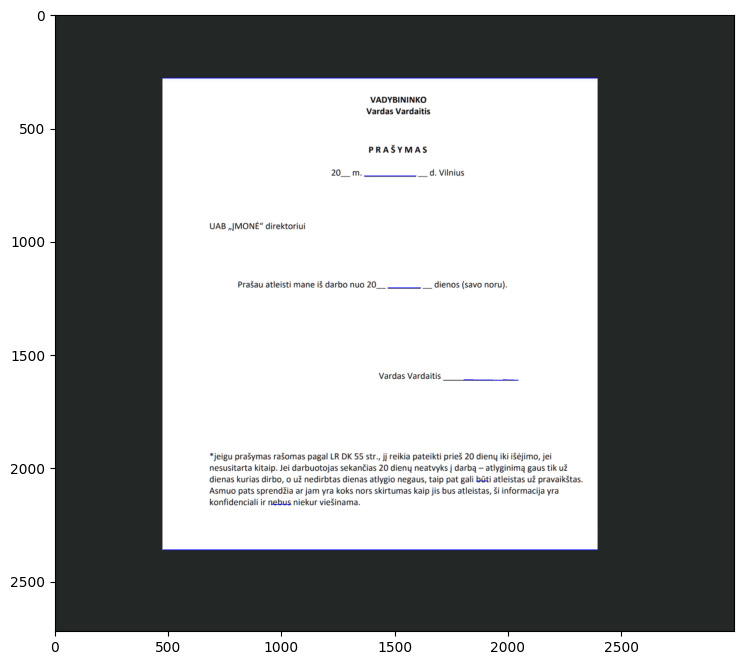

In [84]:
def line_intersects_box(line, box):
    line_x1, line_y1, line_x2, line_y2 = line
    box_x, box_y, box_w, box_h = box

    if (box_x <= line_x1 <= box_x + box_w and box_y <= line_y1 <= box_y + box_h) or \
       (box_x <= line_x2 <= box_x + box_w and box_y <= line_y2 <= box_y + box_h):
        return True

    return False  

for line in aggregated_lines:
    x1, y1, x2, y2 = line
    intersects_box = False
    for box in filtered_boxes:
        if line_intersects_box(line, box):
            intersects_box = True
            break

    if not intersects_box:
        print(line)
        cv2.line(resized_image, (x1, y1), (x2, y2), (0, 0, 255), 2)


plt.figure(figsize=(10, 8))
plt.imshow(resized_image)
plt.show()